In [49]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load times from CVC4 or timeout
def load_cvc4_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    times = {}
    for theorem, entry in data.items():
        if entry['method'] == 'cvc4':
            times[theorem] = entry['total_time'] / 1000 # time is in ms
        else:
            times[theorem] = None
    return times

# Load times from E-Graph file
def load_egraph_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    return {theorem: float(entry['summary']['total_time']) for theorem, entry in data.items() if entry['summary']['stop_reason'] == {"Other":"Found equivalence"}}

# Load all three sources
file1 = './data/rover/lemma.json'
file2 = './data/rover/no_lemma.json'
file3 = './data/rover/egraph_stats.json'

lemma_times = load_cvc4_data(file1)
no_lemma_times = load_cvc4_data(file2)
egraph_times = load_egraph_data(file3)

# Combine into a DataFrame
df = pd.DataFrame({
    'lemma': lemma_times,
    'no_lemma': no_lemma_times,
    'egraph': egraph_times
})

df.sort_values(by=['lemma', 'egraph'], ascending=False, na_position='first')

,lemma,no_lemma,egraph
one_to_two_mult,NaN,NaN,0.000289
merge_left_shift,NaN,NaN,0.000196
add_right_shift,NaN,NaN,0.000178
merge_right_shift,NaN,NaN,0.000156
left_shift_mult,NaN,NaN,0.000144
sum_same,304.438,303.212,0.000032
left_shift_add_2,304.078,NaN,0.000188
left_shift_add_1,303.775,NaN,0.000265
mul_two,301.619,NaN,0.000020
add_assoc_1,109.407,NaN,0.000129


In [62]:
latex_table = df.to_latex(
    index=True,       # include theorem names
    na_rep='-',       # replace NaNs with dashes
    float_format="%.3g"  # format floats
)

print(latex_table)
with open("./out/rover_table.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{lrrr}
\toprule
 & lemma & no_lemma & egraph \\
\midrule
merge_left_shift & - & - & 0.000196 \\
merge_right_shift & - & - & 0.000156 \\
left_shift_add_1 & 304 & - & 0.000265 \\
left_shift_add_2 & 304 & - & 0.000188 \\
add_right_shift & - & - & 0.000178 \\
left_shift_mult & - & - & 0.000144 \\
one_to_two_mult & - & - & 0.000289 \\
commutativity_add & 51 & 51.2 & 4.76e-05 \\
commutativity_mult & 3.56 & 51.3 & 2.86e-05 \\
mult_assoc_1 & 51 & - & 0.000145 \\
mult_assoc_2 & 92.2 & - & 0.000137 \\
mult_assoc_3 & 51.6 & - & 9.72e-05 \\
mult_assoc_4 & 51.4 & - & 0.000136 \\
add_assoc_1 & 109 & - & 0.000129 \\
add_assoc_2 & 51.8 & - & 9.43e-05 \\
add_assoc_3 & 57.3 & - & 0.000132 \\
add_assoc_4 & 51.6 & - & 9.23e-05 \\
dist_over_add & 51.7 & - & 0.00014 \\
sum_same & 304 & 303 & 3.17e-05 \\
mult_sum_same & 103 & - & 0.000245 \\
add_zero & 52.1 & 304 & 6.61e-05 \\
sub_to_neg & 4.54 & 4.66 & 2.47e-05 \\
mul_one & 51.7 & - & 7.72e-05 \\
mul_two & 302 & - & 1.96e-05 \\
\bottomrule
\e

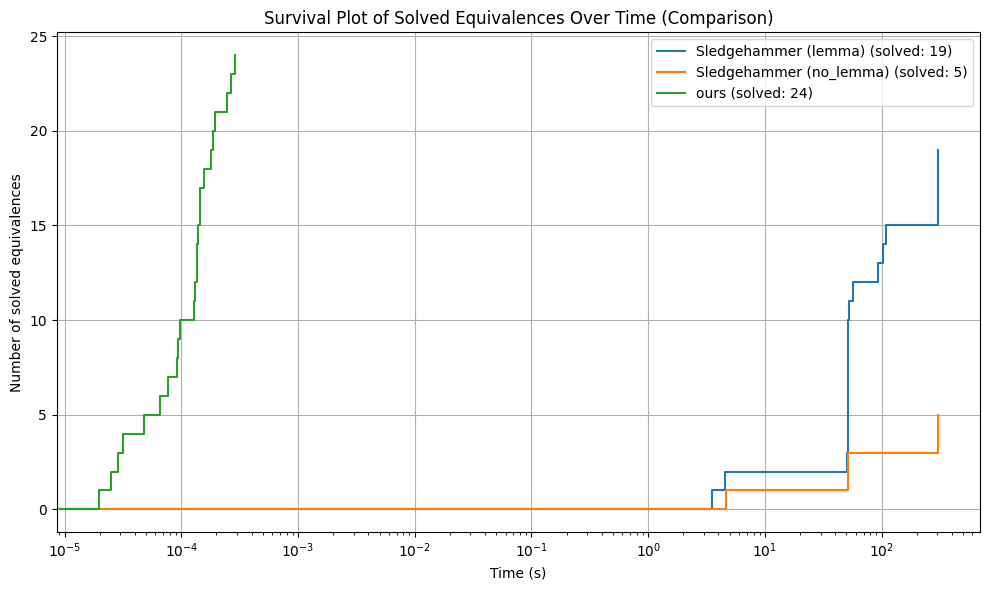

In [35]:

# Function to prepare step data for plotting
def prepare_step_data(series):
    times = sorted([t for t in series.dropna() if t is not None])
    x = [0]
    y = [0]
    for i, t in enumerate(times, start=1):
        x.extend([t, t])
        y.extend([y[-1], i])
    return x, y

# Prepare data for plotting
x1, y1 = prepare_step_data(df['lemma'])
x2, y2 = prepare_step_data(df['no_lemma'])
x3, y3 = prepare_step_data(df['egraph'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, drawstyle='steps-post', label=f'Sledgehammer (lemma) (solved: {len(df["lemma"].dropna())})')
plt.plot(x2, y2, drawstyle='steps-post', label=f'Sledgehammer (no_lemma) (solved: {len(df["no_lemma"].dropna())})')
plt.plot(x3, y3, drawstyle='steps-post', label=f'ours (solved: {len(df["egraph"].dropna())})')

plt.xlabel('Time (s)')
plt.ylabel('Number of solved equivalences')
plt.title('Survival Plot of Solved Equivalences Over Time (Comparison)')
plt.xscale('log')
# plt.ylim([0, 24])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./out/rover_cactus.pdf')
plt.show()
